# Project - COVID-19 New Jersey Trends & Impact on RideSharing Platform

In [0]:
import pandas as pd
# import the seaborn module
import seaborn as sns
import matplotlib.pyplot as plt
import datetime  as dt
import numpy as np
from matplotlib.ticker import PercentFormatter
import os
import missingno as msno # visualize the distribution of NaN values
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import plotly
from datetime import datetime
import dexplot as dxp
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

# import plotly.graph_objects
# from plotly.subplots import make_subplots

#### COVID-19 Dataset --> We have taken New Jersey covid19 data
source --> 
https://covidtracking.com/api/v1/states/daily.csv

#### X Dataset --> We are trying to observe the impact of COVID-19 on the stock prices of major Ridesharing Players (Uber + Lyft)
Source -->
https://finance.yahoo.com/quote/UBER/history?p=UBER

https://finance.yahoo.com/quote/LYFT/history?p=LYFT

Project Git Repository --> https://github.com/marif1901/COVID19_NJ_ImpactAnalysis

## Part 1: Data Pre Processing (10%)

In [0]:
cov_url= 'https://raw.githubusercontent.com/marif1901/COVID19_NJ_ImpactAnalysis/master/COVID19_NJ_Data.csv'
x_uber_url= "https://raw.githubusercontent.com/marif1901/COVID19_NJ_ImpactAnalysis/master/UBER_1Y.csv"
x_lyft_url= "https://raw.githubusercontent.com/marif1901/COVID19_NJ_ImpactAnalysis/master/LYFT_1Y.csv"


###### Reading Datasets

In [0]:
covid = pd.read_csv(cov_url,sep=',')# use sep="," for coma separation. 
xuber = pd.read_csv(x_uber_url,sep=',')
xlyft = pd.read_csv(x_lyft_url,sep=',')
print(covid.columns)
print(xuber.columns)
print(xlyft.columns)

Index(['date', 'state', 'positive', 'negative', 'pending',
       'hospitalizedCurrently', 'hospitalizedCumulative', 'inIcuCurrently',
       'inIcuCumulative', 'onVentilatorCurrently', 'onVentilatorCumulative',
       'recovered', 'dataQualityGrade', 'lastUpdateEt', 'hash', 'dateChecked',
       'death', 'hospitalized', 'total', 'totalTestResults', 'posNeg', 'fips',
       'deathIncrease', 'hospitalizedIncrease', 'negativeIncrease',
       'positiveIncrease', 'totalTestResultsIncrease', 'dailypositvecases',
       'dailynegativecases', 'dailytestingdone', 'dailydeath'],
      dtype='object')
Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')
Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')


###### Preprocessing on COVID Data

In [0]:
covid_cols= ['date','dailypositvecases','dailynegativecases','dailydeath','dailytestingdone',
             'positiveIncrease','negativeIncrease', 'deathIncrease','totalTestResultsIncrease',
            'positive', 'negative', 'death','totalTestResults']
covid_sel= covid[covid_cols].copy()

covid_cols= ['date','dailypositvecases','dailynegativecases','dailydeath','dailytestingdone',
             'positiveIncrease','negativeIncrease', 'deathIncrease','totalTestResultsIncrease',
            'cumpositive', 'cumnegative', 'cumdeath','cumtotalTestResults']

covid_sel.columns=  covid_cols

###### Dropping rows where data is NA

In [0]:
count_nulls= sum(pd.isna(covid_sel['date']))
print('\033[1m' + ' Total nulls found :' + str(count_nulls))
index = covid_sel[pd.isna(covid_sel['date'])].index
covid_sel.drop(index , inplace=True)

 Total nulls found :0


###### Converting date to proper %Y%m%d format

In [0]:
covid_sel['date']= covid_sel['date'].astype(str)
covid_sel['date'] = pd.to_datetime(covid_sel['date'], format='%Y%m%d').dt.strftime("%Y-%m-%d");


In [0]:
int_col= ['dailypositvecases','dailynegativecases','dailydeath','dailytestingdone',
             'positiveIncrease','negativeIncrease', 'deathIncrease','totalTestResultsIncrease',
            'cumpositive', 'cumnegative', 'cumdeath','cumtotalTestResults']
covid_sel[int_col] = covid_sel[int_col].convert_objects(convert_numeric=True)
covid_sel.head()

,date,dailypositvecases,dailynegativecases,dailydeath,dailytestingdone,positiveIncrease,negativeIncrease,deathIncrease,totalTestResultsIncrease,cumpositive,cumnegative,cumdeath,cumtotalTestResults
0,2020-05-07,68760,90580,4341,159340,1745,1993,252,3738,133635,159023,8801,292658
1,2020-05-06,64875,68443,4460,133318,1297,0,305,1297,131890,157030,8549,288920
2,2020-05-05,67015,88587,4089,155602,2324,8079,334,10403,130593,157030,8244,287623
3,2020-05-04,63578,68443,4155,132021,1525,629,39,2154,128269,148951,7910,277220
4,2020-05-03,64691,80508,3755,145199,3027,9727,129,12754,126744,148322,7871,275066


In [0]:
print('\033[1m' +'Min Date observed for COVID : ' + str(covid_sel['date'].min()))
print('\033[1m' + 'Max Date observed for COVID: ' + str(covid_sel['date'].max()))

Min Date observed for COVID : 2020-03-05
Max Date observed for COVID: 2020-05-07


###### Preprocessing on X Data

In [0]:
x_cols= ['Date','Close','Volume']

xuber_sel= xuber[x_cols].copy()
xlyft_sel= xlyft[x_cols].copy()

x_cols= ['date','UberClosingPrice','UberVolume']
xuber_sel.columns= x_cols

x_cols= ['date','LyftClosingPrice','LyftVolume']
xlyft_sel.columns=x_cols

In [0]:
xuber_sel.date= pd.to_datetime(xuber_sel['date']).dt.strftime('%Y-%m-%d')
xlyft_sel.date=pd.to_datetime(xlyft_sel['date']).dt.strftime('%Y-%m-%d')

In [0]:
x_sel= pd.merge(xuber_sel, xlyft_sel,on='date')
print('\033[1m' + 'Min Date observed for X : ' + str(x_sel['date'].min()))
print('\033[1m' + 'Max Date observed for X: ' + str(x_sel['date'].max()))

Min Date observed for X : 2019-05-10
Max Date observed for X: 2020-05-07


In [0]:
x_sel.head()

,date,UberClosingPrice,UberVolume,LyftClosingPrice,LyftVolume
0,2019-05-10,41.570000,186322500,51.090000,23111200
1,2019-05-13,37.099998,79442400,48.150002,10007400
2,2019-05-14,39.959999,46661100,50.520000,7007400
3,2019-05-15,41.290001,36086100,54.040001,7909300
4,2019-05-16,43.000000,38115500,55.599998,7101700


###### Merging COVID data with X Data for Analysing impact in the same time frame

In [0]:
comb_df= covid_sel.merge(x_sel, how='inner', on='date')
comb_df=comb_df.drop_duplicates()
print('\033[1m' + 'Min Date observed for comb_df : ' + str(comb_df['date'].min()))
print('\033[1m' + 'Max Date observed for comb_df: ' + str(comb_df['date'].max()))

Min Date observed for comb_df : 2020-03-05
Max Date observed for comb_df: 2020-05-07


###### Filtering 8 weeks timeframe for Analysis, Starting Date from. Monday 9th March, End Date Sunday 3rd May

In [0]:
st_dt= pd.to_datetime('2020-03-09').strftime('%Y-%m-%d')
# print(st_dt)
end_dt= pd.to_datetime('2020-05-04').strftime('%Y-%m-%d')
# print(end_dt)

comb_df = comb_df[ (comb_df['date']>=st_dt) & (comb_df['date']<= end_dt)] 

print('\033[1m' + 'Min Date observed for comb_df : ' + str(comb_df['date'].min()))
print('\033[1m' + 'Max Date observed for comb_df: ' + str(comb_df['date'].max()))
print('\033[1m' + 'Total Rows * cols: ' + str(comb_df.shape))

comb_df.head(3)

Min Date observed for comb_df : 2020-03-09
Max Date observed for comb_df: 2020-05-04
Total Rows * cols: (40, 17)


,date,dailypositvecases,dailynegativecases,dailydeath,dailytestingdone,positiveIncrease,negativeIncrease,deathIncrease,totalTestResultsIncrease,cumpositive,cumnegative,cumdeath,cumtotalTestResults,UberClosingPrice,UberVolume,LyftClosingPrice,LyftVolume
3,2020-05-04,63578,68443,4155,132021,1525,629,39,2154,128269,148951,7910,277220,27.420000,23428300,27.030001,13393000
4,2020-05-01,61664,70781,3626,132445,2538,6089,310,8627,121190,135355,7538,256545,28.389999,19290200,29.605000,7339100
5,2020-04-30,59526,64574,3912,124100,2388,4212,458,6600,118652,129266,7228,247918,30.270000,20095400,32.830002,4624500


###### Assigning Week Number

In [0]:
comb_df['WeekNum'] = ((pd.to_datetime(comb_df['date']) - pd.to_datetime(st_dt)).dt.days)//7 +1
# weeklycount=comb_df['WeekNum'].value_counts()
# weeklycount

###### Checking Nullity and Data Completeness

Text(0.5, 1.0, 'Data Completenss Check for Combined data')

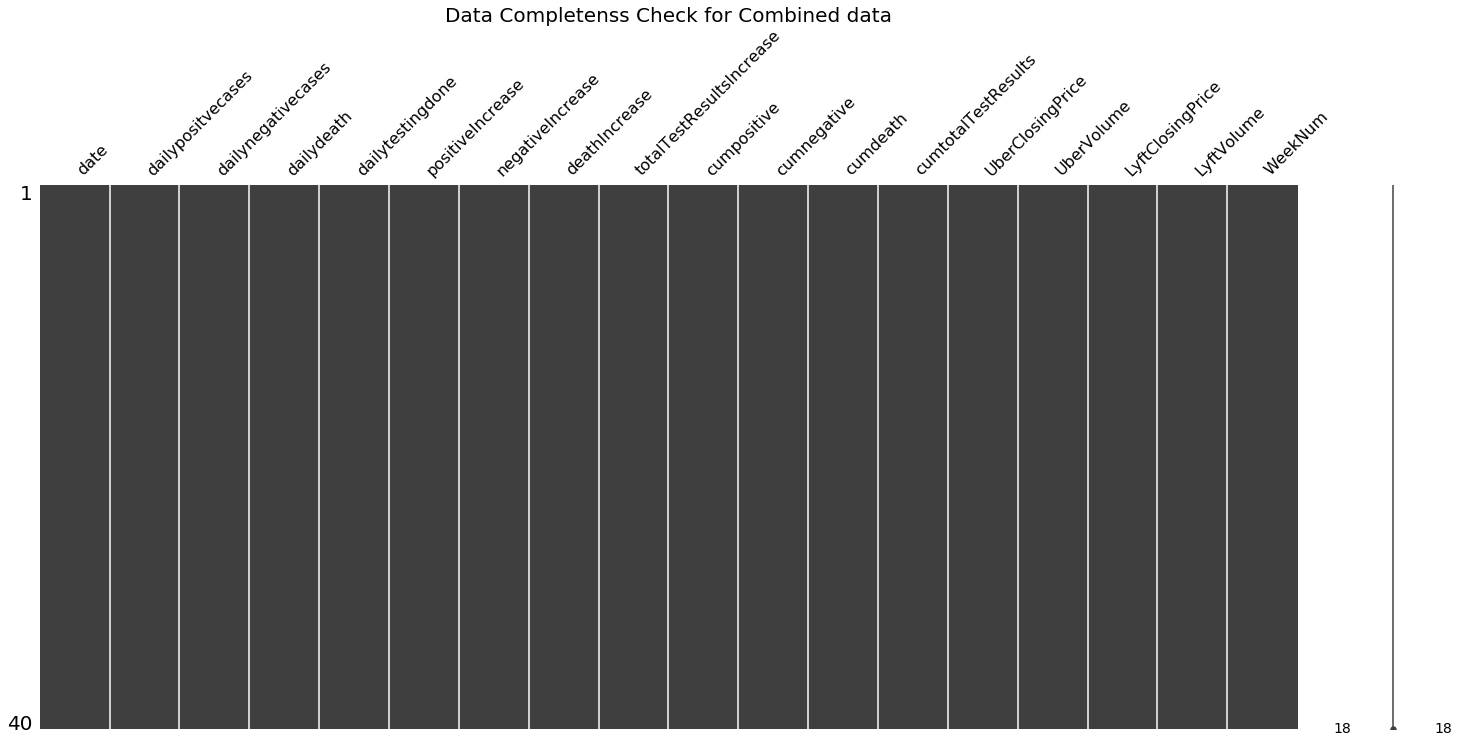

In [0]:
msno.matrix(comb_df)
plt.title('Data Completenss Check for Combined data', size = 20)

###### No Nullity found above

comb_df is the master data set that is preserved through out the exercise for analysis

In [0]:
comb_df= comb_df.sort_values(by="date")
print(comb_df.shape)

(40, 18)


## Part 2: General Trends in Covid + X Data (10%)

###### Day on Day Trends | PDF  | CDF of COVID 19 Growth

In [0]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=comb_df['date'], y=comb_df['dailypositvecases'], 
                         mode='lines+markers', name='Confirmed'))
fig.add_trace(go.Scatter(x=comb_df['date'], y=comb_df['dailydeath'], 
                         mode='lines+markers', name='Deaths'))
fig.add_trace(go.Scatter(x=comb_df['date'], y=comb_df['dailynegativecases'], 
                         mode='lines+markers', name='Negative'))

fig.update_layout(
        xaxis_title="",
        yaxis_title="",
        title = '[Daily Cases] - Confirmed, Deaths & Negative'
#         yaxis_type="log"
    )
fig.show()

###### Let's check the distribution of data for Confirmed Cases, Negative Cases and Deaths

Text(0.5, 0.98, 'Distribution of Day on Day in Confirmed Cases | Negative Cases & Deaths')

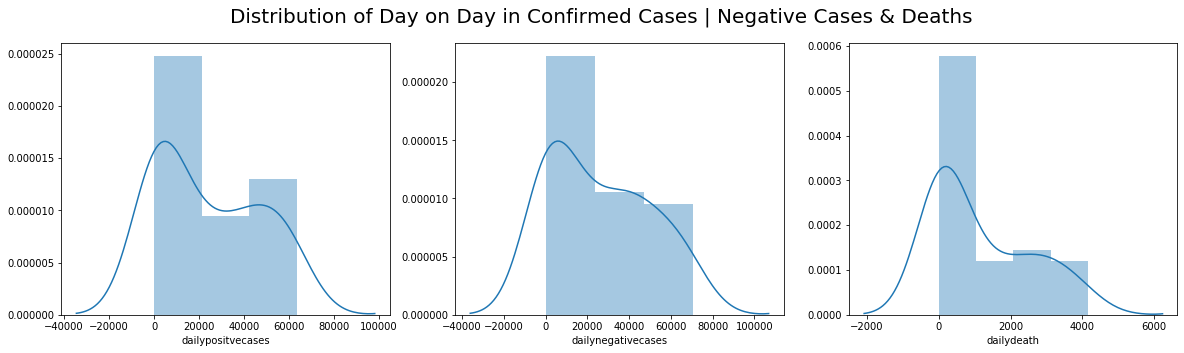

In [0]:
#histogram
fig = plt.figure(figsize= (20,5))
plt.subplot(1,3,1)
sns.distplot(comb_df['dailypositvecases'])

plt.subplot(1,3,2)
sns.distplot(comb_df['dailynegativecases'])

plt.subplot(1,3,3)
sns.distplot(comb_df['dailydeath'])

fig.suptitle("Distribution of Day on Day in Confirmed Cases | Negative Cases & Deaths", fontsize=20)


###### Inference from above graph: we can clearly see that for confirmed and positive cases it follows a smooth curve with fluctuations while death is mostly uniform after certain number of days so its flat in nature 

In [0]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=comb_df['date'], y=comb_df['cumpositive'], 
                         mode='lines+markers', name='Confirmed'))
fig.add_trace(go.Scatter(x=comb_df['date'], y=comb_df['cumdeath'], 
                         mode='lines+markers', name='Deaths'))
fig.add_trace(go.Scatter(x=comb_df['date'], y=comb_df['cumnegative'], 
                         mode='lines+markers', name='Negative'))

fig.update_layout(
        xaxis_title="",
        yaxis_title="",
#         title = 'Cumulative -> Confirmed, Deaths & Negative Results'
        title = 'CDF [Log Scale]-> Confirmed, Deaths & Negative Results',
        yaxis_type="log"
    )
fig.show()

###### Inference from above graph: It can be observed there was a steep increase in the confirm cases from Mar9 to Apr6 since then the rate of increase seems to be decreasing and curve looks to be flattening after Apr20 while death is observed to be increasing at constant pace

In [0]:
df_t= comb_df.copy()
df_t['Positive Rate'] = df_t['cumpositive']/df_t['cumtotalTestResults']
df_t['Negative Rate'] = df_t['cumnegative']/df_t['cumtotalTestResults']

df_t['Death Rate'] = df_t['cumdeath']/df_t['cumpositive']



fig = go.Figure()
fig.add_trace(go.Scatter(x=df_t['date'], y=df_t['Positive Rate'], 
                         mode='lines+markers', name='Positive Rate'))
fig.add_trace(go.Scatter(x=df_t['date'], y=df_t['Negative Rate'], 
                         mode='lines+markers', name='Negative Rate'))
fig.add_trace(go.Scatter(x=df_t['date'], y=df_t['Death Rate'], 
                         mode='lines+markers', name='Death Rate'))
fig.update_layout(
        xaxis_title="",
        yaxis_title="",
        title = 'Confirmed Rate, Negative Rate & Death Rate'
#         yaxis_type="log"
    )
fig.show()


###### Inference from above graph: This is interesting that in the intial few days of the outbreak there are mostly postive cases, this is due to testing being limited to high potential people whle we can see that with time testing has picked up and negative and positive cases seems to be breaking even in the current scenario and negative cases are more after the complete lockdown, while death rate seems to be gently increasing 

In [0]:
## Sketch Pre period also for this
lockdown_dt= pd.to_datetime('2020-03-18').strftime('%Y-%m-%d')
x_sel['Period']= np.where(x_sel['date'] >= lockdown_dt, 'PostLockdown', 'PreLockdown')

x_sel['UberTradedStocks']= x_sel['UberVolume']* x_sel['UberClosingPrice']
x_sel['LyftTradedStocks']= x_sel['LyftVolume'] * x_sel['LyftClosingPrice']


Text(0.5, 0.98, 'Day on Day #Traded Stockcs  of Uber | Lyft Pre v/s Post Lockdown Period')

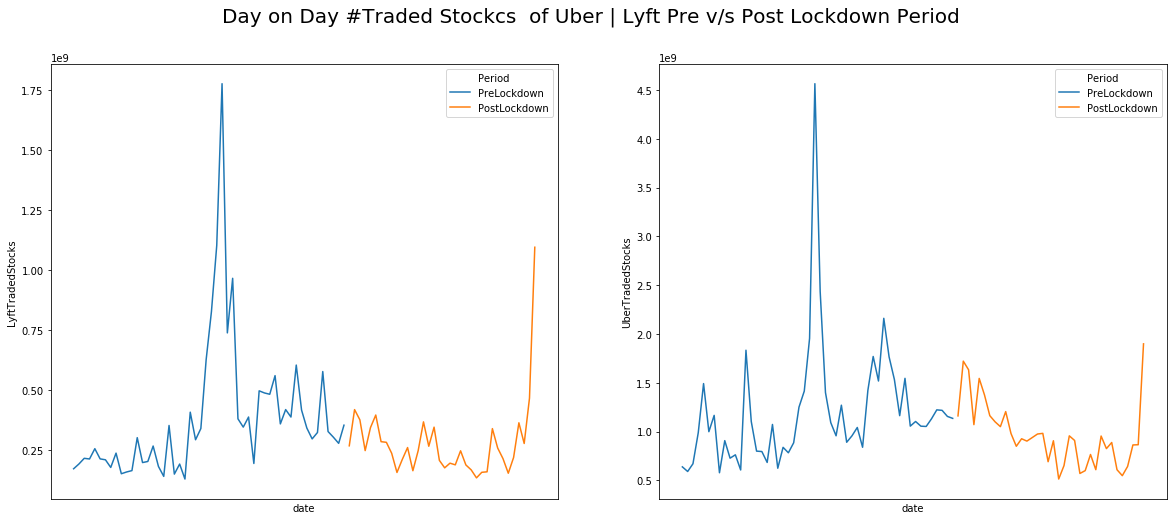

In [0]:
time_eda= pd.to_datetime('2020-01-01').strftime('%Y-%m-%d')
x_tmp= x_sel.copy()
x_tmp = x_tmp[x_tmp['date']>=time_eda] 

fig = plt.figure(figsize= (20,8))
plt.subplot(1,2,1)

g =sns.lineplot(x="date", y="LyftTradedStocks",
              hue="Period",
              data=x_tmp)
g.set(xticks=[])

plt.subplot(1,2,2)
g =sns.lineplot(x="date", y="UberTradedStocks",
              hue="Period",
              data=x_tmp)
g.set(xticks=[])
fig.suptitle("Day on Day #Traded Stockcs  of Uber | Lyft Pre v/s Post Lockdown Period", fontsize=20)


###### Inference from above graph: We can clearly see that COVID19 outbreak has very badly hit ride sharing market, traded stocks have gone down by very high rate, can be seen from the pre v/s post lockdown period 

In [0]:
df_temp= comb_df.copy()
df_temp['Uber_pctChange'] = df_temp['UberClosingPrice'].pct_change(periods=1)
df_temp['Lyft_pctChange'] = df_temp['LyftClosingPrice'].pct_change(periods=1)
df_temp['Confirmed_pctChange'] = df_temp['cumpositive'].pct_change(periods=1)
df_temp = df_temp.iloc[1:]
# df_temp.head()

fig = go.Figure()
fig.add_trace(go.Scatter(x=df_temp['date'], y=df_temp['Confirmed_pctChange'], 
                         mode='lines+markers', name='Confirmed_pctChange'))

fig.add_trace(go.Scatter(x=df_temp['date'], y=df_temp['Uber_pctChange'], 
                         mode='lines+markers', name='Uber_pctChange'))

fig.add_trace(go.Scatter(x=df_temp['date'], y=df_temp['Lyft_pctChange'], 
                         mode='lines+markers', name='Lyft_pctChange'))

fig.update_layout(
        xaxis_title="",
        yaxis_title="",
        title = 'Velocity of -> Confirmed Cases , LyftClosingPrice & UberClosingPrice'
#         title = 'CDF [Log Scale]-> Confirmed, Deaths & Negative Results',
#         yaxis_type="log"
    )
fig.show()

Text(0.5, 0.98, 'Histogram of Precentage Change Day on Day in Stock Prices of Uber | Lyft & Confirmed Cases')

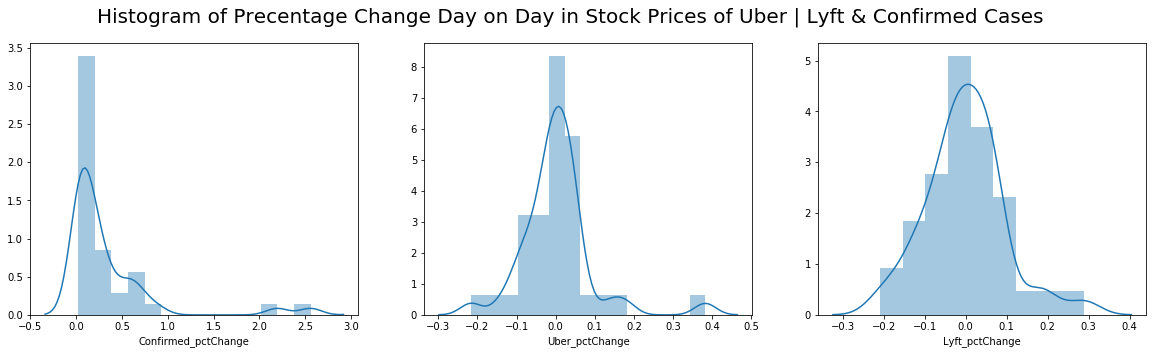

In [0]:
#histogram
fig = plt.figure(figsize= (20,5))
plt.subplot(1,3,1)
sns.distplot((df_temp['Confirmed_pctChange']))

plt.subplot(1,3,2)
sns.distplot(df_temp['Uber_pctChange'], label="Uber Changes")

plt.subplot(1,3,3)
sns.distplot((df_temp['Lyft_pctChange']))


# plt.title('Distribution of scores assigned to every house',size= 20)
fig.suptitle("Histogram of Precentage Change Day on Day in Stock Prices of Uber | Lyft & Confirmed Cases", fontsize=20)



###### Inference from above graph: As the velocity in the Positive Cases increases we see that velocity in the Uber & Lyft Price decreases and when the velocity of confirm cases decreases then velocity in the Stock Prices of Uber Lyft Increases,
###### Changes in the confirmed cases is right skewed which suggests increasing cases while for Uber & Lyft we see that its left skewed which shows a constant decline in this Stock Prices while Lyft has smooth fluctuation

In [0]:
df_temp=comb_df.copy()
df_temp['Country_Region']= 'NJ'
df_temp['Lat']= 39.833851
df_temp['Long']= -74.871826

df_temp = df_temp.groupby(['date', 'Country_Region','Lat','Long'])['cumpositive', 'cumdeath'].max().reset_index()
df_temp["date"] = pd.to_datetime(df_temp["date"]).dt.strftime('%m/%d/%Y')
df_temp.columns=['Last_Update','Country_Region','Lat','Long','Confirmed','Deaths']
df_temp['Confirmed'].fillna(0, inplace=True)
df_temp.sort_values('Confirmed', ascending=False).head()

,Last_Update,Country_Region,Lat,Long,Confirmed,Deaths
39,05/04/2020,NJ,39.833851,-74.871826,128269,7910
38,05/01/2020,NJ,39.833851,-74.871826,121190,7538
37,04/30/2020,NJ,39.833851,-74.871826,118652,7228
36,04/29/2020,NJ,39.833851,-74.871826,116264,6770
35,04/28/2020,NJ,39.833851,-74.871826,113856,6442


In [0]:
fig = px.scatter_geo(df_temp,
                     #locations="Country_Region",
                     locationmode='country names',
                     lat='Lat', lon='Long',
                     #hover_name="Country_Region",
                     hover_data=["Confirmed", "Deaths"], animation_frame="Last_Update",
                     color=np.log10(df_temp["Confirmed"]+1)-1, size=np.power(df_temp["Confirmed"]+1, 0.3)-1,
                     range_color= [0, max(np.log10(df_temp["Confirmed"]+1))],
                     title="COVID-19 Progression Animation Over Time",
                     color_continuous_scale=px.colors.sequential.Plasma,
                     projection="natural earth"
                    )
fig.update_coloraxes(colorscale="hot")
fig.update(layout_coloraxis_showscale=False)
#fig.update_coloraxes(colorbar_title="Color (Confirmed Cases Log Scale)")
fig.show()

In [0]:
fig = px.choropleth(df_temp,
                    locations="Country_Region",
                    locationmode="USA-states",
                    #lat='Lat', lon='Long',
                    hover_name="Country_Region",
                    hover_data=["Confirmed", "Deaths"], animation_frame="Last_Update",
                    color=np.log10(df_temp["Confirmed"]), 
                     
                    title="COVID-19 Progression Animation in New Jersey Over Time",
                    color_continuous_scale=px.colors.sequential.Plasma,
                    scope="usa",
                   )
fig.update(layout_coloraxis_showscale=False)
fig.show()


## Part 3: Required Inferences (50%)

### 3.1 Predicting the COVID19 fatality & #cases over next one week

Use your COVID19 dataset to predict the COVID19 fatality and #cases for the next one week. Use the following four prediction techniques: (i) AR(3), (ii) AR(5), (iii) EWMA with alpha = 0.5, and (iv) EWMA with alpha = 0.8. Make sure that your dataset allows you to verify the one week prediction. For example, use the first three weeks of data to predict the fourth week, and report the accuracy of your predictions using the actual fourth week data. Use metrics learned in class (MAPE as a % and MSE) to report accuracy numbers.

#### 3.1.1 AR(3)

#### 3.1.2 AR(5)

#### 3.1.3 EWMA with alpha = 0.5

#### 3.1.4 EWMA with alpha = 0.8

### 3.2 Apply the Wald’s test, Z-test, and t-test to check whether the mean of COVID19 deaths and #cases are different from the first week to the last week

Apply the Wald’s test, Z-test, and t-test (assume all are applicable) to check whether the mean of COVID19 deaths and #cases are different from the first week to the last week in your dataset. Use MLE for Wald’s test as the estimator. Note, you have to report results for deaths and #cases separately, so think of this as two inferences. After running the test and reporting the numbers, check and comment on whether the tests are applicable or not. First use one-sample tests by computing the mean of the first week data and using that as guess for last week data. Then, repeat with a two-sample version of Wald and t-tests. For t-test, use both paired and unpaired tests. Use alpha value of 0.05 for all. For t-test, the threshold to check against is tn-1, alpha/2 for two-tailed and tn-1, alpha for one-tailed, where n is the number of data points. You can find these values in online t tables, similar to z tables.

### Data Preprocessing

In [0]:
covid_sel.head(2)

,date,dailypositvecases,dailynegativecases,dailydeath,dailytestingdone,positiveIncrease,negativeIncrease,deathIncrease,totalTestResultsIncrease,cumpositive,cumnegative,cumdeath,cumtotalTestResults
0,2020-05-07,68760,90580,4341,159340,1745,1993,252,3738,133635,159023,8801,292658
1,2020-05-06,64875,68443,4460,133318,1297,0,305,1297,131890,157030,8549,288920


In [0]:
st_dt = pd.to_datetime('2020-03-09').strftime('%Y-%m-%d')
# print(st_dt)
end_dt= pd.to_datetime('2020-05-04').strftime('%Y-%m-%d')
# print(end_dt)

covid_sel_2 = covid_sel[ (covid_sel['date']>=st_dt) & (covid_sel['date']<= end_dt)] 
covid_sel_2 = covid_sel_2.sort_values('date')


In [0]:
covid_sel_2 = covid_sel_2.tail(14)

In [0]:

test_df = covid_sel_2[['dailypositvecases', 'dailydeath' ,'date']] 
week_1 = test_df.head(7)
week_1_cases = week_1['dailypositvecases'].tolist()
w1_deaths = week_1['dailydeath'].tolist()



last_week_df = test_df.tail(7)
week_last_cases = last_week_df['dailypositvecases'].tolist()
w_last_deaths =  last_week_df['dailydeath'].tolist()

### 3.2.1 One Sample tests 

### First Hypothesis

#### H0 : Mean of COVID19 DAILY POSITIVE CASES are same for the second last week and last week 
#### HA : Mean of COVID19 DAILY POSITIVE CASES are NOT same for the second last week and last week


---




### Second Hypothesis

#### H0: Mean of number of COVID19 deaths are same for the second last and last week 
#### HA : Mean of COVID19 deaths are NOT same for the second last week and last week

**One sample Wald's Test**

In [0]:
import math
def get_parameters_mle(X):
    # assuming Poisson Distribution
    lambda_hat = np.mean(X)
    se_hat = math.sqrt(lambda_hat)
    return lambda_hat, se_hat

def get_walds_statistic(theta_0,data):
    theta_hat, se_hat = get_parameters_mle(data)
    w_stat = (theta_hat - theta_0) / se_hat
    return w_stat

# For daily positive cases - 
theta_0_cases = np.mean(week_1_cases)
w_stat = get_walds_statistic(theta_0_cases, week_last_cases)
print("\n\nThe Wald's Statistic for the first hypothesis is ",w_stat )
z_a2 = 1.96 
if abs(w_stat) <= z_a2:
    print("Accept the first Hypothesis (Daily Cases) ")
else:
    print("Reject the first Hypothesis (Daily Cases) ")

# For daily deaths - 

theta_0_deaths = np.mean(w1_deaths)
w_stat_2 =get_walds_statistic(theta_0_deaths, w_last_deaths)
print("\n\nThe Wald's Statistic for the Second hypothesis is ",w_stat_2 )

if abs(w_stat_2) <= z_a2:
    print("Accept the second Hypothesis (Daily deaths) ")
else:
    print("Reject the second Hypothesis (Daily deaths) ")



The Wald's Statistic for the first hypothesis is  36.961061662245704
Reject the first Hypothesis (Daily Cases) 


The Wald's Statistic for the Second hypothesis is  15.670344607445339
Reject the second Hypothesis (Daily deaths) 


**Assumptions for one sample Wald's Test**


1.   Estimate theta_hat is asymptotically normal

**Does the test apply?**



**One sample Z test**

In [0]:
def get_z_statistic(mu_0, data, sigma_pop):
    sample_mean = np.mean(data)
    n = len(data)
    z_stat = (sample_mean - mu_0) / (sigma_pop /math.sqrt(n))
    return z_stat

mu_0_cases = np.mean(week_1_cases)
mu_0_deaths = np.mean(w1_deaths)
population_cases_sigma = covid_sel['dailypositvecases'].std()
population_deaths_sigma = covid_sel['dailydeath'].std()

# For daily positive cases - 

z_stat = get_z_statistic(mu_0_cases, week_last_cases, population_cases_sigma)
print("\n\nThe Z Statistic for the first hypothesis is ",z_stat )
z_a2 = 1.96 
if abs(z_stat) < z_a2:
    print("Accept the first Hypothesis (Daily Cases) ")
else:
    print("Reject the first Hypothesis (Daily Cases) ")

# For daily deaths - 

z_stat_2 =get_z_statistic(mu_0_deaths, w_last_deaths, population_deaths_sigma)
print("\n\nThe Z Statistic for the Second hypothesis is ",z_stat_2 )

if abs(z_stat_2) <= z_a2:
    print("Accept the second Hypothesis (Daily deaths) ")
else:
    print("Reject the second Hypothesis (Daily deaths) ")



The Z Statistic for the first hypothesis is  1.0034904939513414
Accept the first Hypothesis (Daily Cases) 


The Z Statistic for the Second hypothesis is  1.707520299137009
Accept the second Hypothesis (Daily deaths) 


**Assumptions for one sample Z Test**


1.   Since n is small in our case (CLT won't apply) , We can only use Z test if {X1, X2 .. Xn} are iid Nor(u, sigma square)
2.   True standard deviation of the entire data is known 

**Does the test apply?**
Z test wont work if n is small and sample is not normally distributed. 

From our tests from the following part we see that our sample is infact not normally distributed. 
Hence Z test will not apply. 


---



---



**One sample t test**

In [0]:
dof = len(week_last_cases) - 1
print(dof)
alpha = 0.05
t_val = 2.4469

6


In [0]:

def get_sample_sd(D):
	mean = np.mean(D)
	sq_sum = sum([(i - mean) * (i-mean) for i in D])
	return math.sqrt(sq_sum / len(D))
 
def get_t_statistic(mu_0, data):
    sample_std = get_sample_sd(data)
    sample_mean = np.mean(data)
    n = len(data)
    w_stat = (sample_mean - mu_0) / (sample_std /math.sqrt(n))
    return w_stat

mu_0_cases = np.mean(week_1_cases)
mu_0_deaths = np.mean(w1_deaths)


# For daily positive cases - 

t_stat = get_t_statistic(mu_0_cases, week_last_cases)
print("\n\nThe T test Statistic for the first hypothesis is ",t_stat )


if abs(t_stat) <= t_val:
    print("Accept the first Hypothesis (Daily Cases) ")
else:
    print("Reject the first Hypothesis (Daily Cases) ")

# For daily deaths - 

t_stat_2 =get_t_statistic(mu_0_deaths, w_last_deaths)
print("\n\nThe T test Statistic for the Second hypothesis is ",t_stat_2 )

if abs(t_stat_2) < t_val:
    print("Accept the second Hypothesis (Daily deaths) ")
else:
    print("Reject the second Hypothesis (Daily deaths) ")



The T test Statistic for the first hypothesis is  9.830213674075742
Reject the first Hypothesis (Daily Cases) 


The T test Statistic for the Second hypothesis is  8.58209342573082
Reject the second Hypothesis (Daily deaths) 


**Assumptions - **


1.   

Applicable as it is useful when n < 30, smaller samples.



### 3.3.2 Two Sample Wald's Test

#### First Hypothesis

##### H0 : Mean of COVID19 DAILY POSITIVE CASES are same for the first week and last week 
##### HA : Mean of COVID19 DAILY POSITIVE CASES are NOT same for the first week and last week


---



---


#### Second Hypothesis

##### H0: Mean of number of COVID19 deaths are same for the first week and last week 
##### HA : Mean of COVID19 deaths are NOT same for the first week and last week

In [0]:
# Create delta 
delta_cases = [i-j for i,j in zip(week_1_cases, week_last_cases)]
delta_deaths = [i-j for i,j in zip(w1_deaths, w_last_deaths)]


delta_hat_cases = np.mean(week_1_cases) - np.mean(week_last_cases)

se_hat_cases = math.sqrt(np.var(delta_cases))

se_hat_deaths = math.sqrt(np.var(delta_deaths))

delta_hat_deaths = np.mean(w1_deaths) - np.mean(w_last_deaths)

w_stat_1 = delta_hat_cases / se_hat_cases

w_stat_2 = delta_hat_deaths / se_hat_deaths

print("\n\nThe Wald's Statistic for the first hypothesis is ",w_stat_1 )
z_a2 = 1.96 
if abs(w_stat_1) <= z_a2:
    print("Accept the first Hypothesis (Daily Cases) ")
else:
    print("Reject the first Hypothesis (Daily Cases) ")

print("\n\nThe Wald's Statistic for the first hypothesis is ",w_stat_1 )
z_a2 = 1.96 
if abs(w_stat_2) <= z_a2:
    print("Accept the first Hypothesis (Daily Cases) ")
else:
    print("Reject the first Hypothesis (Daily Cases) ")




The Wald's Statistic for the first hypothesis is  -6.325057665298436
Reject the first Hypothesis (Daily Cases) 


The Wald's Statistic for the first hypothesis is  -6.325057665298436
Reject the first Hypothesis (Daily Cases) 


### Two sample Paired T test 

In [0]:
# Create delta 
delta_cases = [i-j for i,j in zip(week_1_cases, week_last_cases)]
delta_deaths = [i-j for i,j in zip(w1_deaths, w_last_deaths)]

delta_cases_bar = np.mean(delta_cases)
sample_dev_cases = math.sqrt(np.var(delta_cases))

T = delta_cases_bar / sample_dev_cases

print("\n\nThe T test Statistic for the first hypothesis is ",T )

t_val = 2.4469

if abs(T) <= t_val:
    print("Accept the first Hypothesis (Daily Cases) ")
else:
    print("Reject the first Hypothesis (Daily Cases) ")

delta_cases_deaths = np.mean(delta_deaths)
sample_dev_death = math.sqrt(np.var(delta_deaths))

T = delta_cases_deaths / sample_dev_death

t_val = 2.4469

if abs(T) <= t_val:
    print("Accept the second Hypothesis (Daily deaths) ")
else:
    print("Reject the second Hypothesis (Daily deaths) ")



**Assumption**
The sample D which is the element-wise difference of the two samples (last week and second last week) should be normally distributed. 

### Two sample unpaired T test 

In [0]:
# Create delta 
delta_cases = [i-j for i,j in zip(week_1_cases, week_last_cases)]
delta_deaths = [i-j for i,j in zip(w1_deaths, w_last_deaths)]

delta_cases_bar = np.mean(delta_cases)

var_x_cases = np.var(week_1_cases)
var_y_cases = np.var(week_last_cases)

T = delta_cases_bar / math.sqrt(var_x_cases / len(week_1_cases) + var_y_cases / len(week_last_cases))

print("\n\nThe T test Statistic for the first hypothesis is ",T )

t_val = 2.4469

if abs(T) <= t_val:
    print("Accept the first Hypothesis (Daily Cases) ")
else:
    print("Reject the first Hypothesis (Daily Cases) ")

delta_cases_deaths = np.mean(delta_deaths)

var_x_deaths = np.var(w1_deaths)
var_y_deaths = np.var(w_last_deaths)

T = delta_cases_deaths / math.sqrt(var_x_deaths / len(w1_deaths) + var_y_deaths / len(w_last_deaths))

t_val = 2.4469

if abs(T) <= t_val:
    print("Accept the second Hypothesis (Daily deaths) ")
else:
    print("Reject the second Hypothesis (Daily deaths) ")



The T test Statistic for the first hypothesis is  -6.006919588888745
Reject the first Hypothesis (Daily Cases) 
Reject the second Hypothesis (Daily deaths) 


### 3.3 Equality of distributions (distribution of first week and last week), using K-S test and Permutation test

Repeat inference 2 above but for equality of distributions (distribution of first week and last week), using K-S test and Permutation test. For the K-S test, use both 1-sample and 2-sample tests. For the 1-sample test, try Poisson, Geometric, and Binomial. To obtain parameters of these distributions to check against in 1-sample KS, use MME on first week’s data to obtain parameters of the distribution, and then check whether the last week’s data has the distribution with the obtained MME parameters. Use a threshold of 0.05 for both K-S test and Permutation test.

#### 3.3.1 K-S Test

#### 3.3.2 Permutation Test

### 3.4 Pearson correlation for #deaths and Total Traded Stocks,  #cases and Total Traded Stocks


Report the Pearson correlation value for #deaths and your X dataset, and also for #cases and your X dataset over one month of data. Use the most relevant column in X to compare against the covid numbers.

In [0]:
import math
def p_coeff(a,b):

    ab_n1 = 0 
    ab_d1 = 0 
    ab_d2 = 0

    mean_a = sum(a)/len(a)
    mean_b = sum(b)/len(b)
    for i, j in zip(a,b):
        ab_n1 += (i- mean_a) * (j- mean_b)
        ab_d1 += (i- mean_a) * (i- mean_a)
        ab_d2 += (j- mean_b) * (j- mean_b)
    ab = ab_n1 / (math.sqrt(ab_d1) * math.sqrt(ab_d2))
    return ab

#### Calculating Total Traded Stocks for the Day

In [0]:
comb_df['UberTradedStocks']= comb_df['UberVolume']* comb_df['UberClosingPrice']
comb_df['LyftTradedStocks']= comb_df['LyftVolume'] * comb_df['LyftClosingPrice']

#### 3.4.1 Pearson correlation for #deaths and Total Traded Stocks

In [0]:
corr= p_coeff(comb_df['cumdeath'], comb_df['UberTradedStocks'])
print('\033[1m' + 'Pearsons correlation of #deaths and Stock Price of Uber: %.3f' % corr)

corr = p_coeff(comb_df['cumdeath'], comb_df['LyftTradedStocks'])
print('\033[1m' + 'Pearsons correlation of #deaths and Stock Price of Lyft: %.3f' % corr)


Pearsons correlation of #deaths and Stock Price of Uber: -0.723
Pearsons correlation of #deaths and Stock Price of Lyft: -0.406


######  Inference: We can observe a high negative linear correlation between stock prices of Uber/Lyft v/s the Deaths, this means that increase in #deaths day on day has adversely affected ride sharing company with less people moving out

#### 3.4.2 Pearson correlation for #cases and Stock Price

In [0]:
corr= p_coeff(comb_df['cumpositive'],  comb_df['UberTradedStocks'])
print('\033[1m' + 'Pearsons correlation of #Confirmed Cases and Stock Price of Uber: %.3f' % corr)

corr= p_coeff(comb_df['cumpositive'], comb_df['LyftTradedStocks'])
print('\033[1m' + 'Pearsons correlation of #Confirmed Cases and Stock Price of Lyft: %.3f' % corr)


Pearsons correlation of #Confirmed Cases and Stock Price of Uber: -0.783
Pearsons correlation of #Confirmed Cases and Stock Price of Lyft: -0.478


######  Inference: We can observe a high negative linear correlation between stock prices of Uber/Lyft v/s the #Confirm cases, this means that increase in #Confim cases day on day has brought the city to a halt and ride sharing company stocks are going down as less and less people are moving out

### 3.5 Posterior Distributions for daily deaths parameter estimator 

Assume the daily deaths are Poisson distributed with parameter lambda. Assume an Exponential prior on lambda. Use first week’s data to obtain the posterior for lambda via Bayesian inference. Now, use second week’s data to obtain the new posterior, using prior as posterior after week 1. Repeat till the end of week 4. Plot all posterior distributions on one graph. Report the MAP for all posteriors.

#### 3.5.1 First week to Second week

#### 3.5.2 Second week to third week

#### 3.5.3 Third week to fourth week

#### 3.5.4 Plot all posterior distributions on one graph

#### 3.5.5 Report the MAP for all posteriors

## Part 4: Creative Inferences (30%)

Propose three new inferences for your dataset and solve them using tools learned in class. You will be graded on creativity/practicality of your inferences. For each inference you propose, provide a paragraph of text to explain why this inference is practical and useful. Also comment on the results of your inference, as appropriate. See “Sample inferences section below for ideas. Only use tools/tests learned in class. This will be 30% of the project grade. 

### Hypothesis1: Performing Chi-Square test to show due to Uber Lyft being functional Covid Spread Quickly and once they were shut spread went down

Using Chi-square independence test to check if Uber Stock Prices impacted COVID19 cases

#### Step 1: Define the Hypothesis

###### For this we will be creating two lables for COVID19 changes in Confirmed Cases ("Positive_pctChange") as postive and negative , and similarly changes in Closing price for Uber ("Uber_pctChange") as positive and negative

For our example, the hypothesis are:
H0: The Change in Confirmed Cases(Positive_pctChange) and changes in Closing price for Uber ("Uber_pctChange") are independent (which means they are not associated)
H1: Change in Confirmed Cases and changes in Closing price for Uber are not independent (which means they are associated)

In [0]:
var1= 'UberClosingPrice'
var2= 'cumpositive'

comb_df['Uber_pctChange'] = comb_df[var1].pct_change(periods=1)
comb_df['Confirmed_pctChange'] = comb_df[var2].pct_change(periods=1)
# comb_df['Lyft_pctChange'] = comb_df['LyftClosingPrice'].pct_change(periods=1)
comb_df=comb_df.iloc[1:]

comb_df['Uber_Slope'] = comb_df['Uber_pctChange'].pct_change(periods=1)
comb_df['Confirmed_Slope'] = comb_df['Confirmed_pctChange'].pct_change(periods=1)
# comb_df['Lyft_Slope'] = comb_df['Lyft_pctChange'].pct_change(periods=1)
comb_df=comb_df.iloc[1:]

Crating Lables for Changes in Confirm Cases and Uber's Closing Price Day On Day

In [0]:
comb_df['Confirmed_Label']= np.where(comb_df['Confirmed_Slope'] >= 0, 'Positive', 'Negative')
comb_df['Uber_Label']= np.where(comb_df['Uber_Slope'] >= 0, 'Positive', 'Negative')
# comb_df['Lyft_Label']= np.where(comb_df['Lyft_Slope'] >= 0, 'Positive', 'Negative')


In [0]:
comb_df.iloc[:,20:28].head(2)

,Uber_Slope,Confirmed_Slope,Confirmed_Label,Uber_Label
40,-4.318268,0.650000,Positive,Negative
39,0.468009,-0.583333,Negative,Positive


#### Step2: Choose a significance Level

For the null hypothesis to be rejected the p-value should be less than the significance level.
Lower α values are generally preferred which may be in the range of 0.01 to 0.10.
We choose α = 0.05

#### Step3: Create Contingency table

In [0]:
Q=pd.crosstab(comb_df['Confirmed_Label'], comb_df['Uber_Label'], rownames=['Confirmed_Label'], colnames=['Uber_Label'])
print(Q)

Q_table = comb_df.groupby(['Confirmed_Label','Uber_Label'])['date'].count()
Q_table = Q_table.reset_index()
Q_table.columns = ['Confirmed_Label','Uber_Label','TotalDays']

Uber_Label       Negative  Positive
Confirmed_Label                    
Negative               14         5
Positive               13         6


#### Step4: Calculate Expected Frequency

In [0]:
comb_df.shape
total=  Q_table['TotalDays'].sum()

per_cp= round(Q_table[(Q_table['Confirmed_Label']== 'Positive')].TotalDays.sum()/total,2)
per_up= round(Q_table[(Q_table['Uber_Label']== 'Positive')].TotalDays.sum()/total,2)

ob_cp_up= Q_table[(Q_table['Confirmed_Label']== 'Positive') & (Q_table['Uber_Label'] =='Positive')].TotalDays.sum()
ob_cp_un= Q_table[(Q_table['Confirmed_Label']== 'Positive') & (Q_table['Uber_Label'] =='Negative')].TotalDays.sum()
ob_cn_up= Q_table[(Q_table['Confirmed_Label']== 'Negative') & (Q_table['Uber_Label'] =='Positive')].TotalDays.sum()
ob_cn_un= Q_table[(Q_table['Confirmed_Label']== 'Negative') & (Q_table['Uber_Label'] =='Negative')].TotalDays.sum()

ex_cp_up= per_cp*per_up*total
ex_cp_un= per_cp*(1-per_up)*total
ex_cn_up= (1-per_cp)*per_up*total
ex_cn_un= (1-per_cp)*(1-per_up)*total


print(total, per_cp, per_up, ob_cp_up, ob_cp_un, ob_cn_up, ob_cn_un, ex_cp_up, ex_cp_un, ex_cn_up, ex_cn_un)

38 0.5 0.29 6 13 5 14 5.51 13.489999999999998 5.51 13.489999999999998


#### Step5: Calculate Chi-Square Statistic

In [0]:
def diff_sq(Obs, Exp):
    return ((Obs-Exp)**2)/Exp

In [0]:
Q= diff_sq(ob_cp_up, ex_cp_up) + diff_sq(ob_cp_un, ex_cp_un) + diff_sq(ob_cn_up, ex_cn_up) + diff_sq(ob_cn_un, ex_cn_un)

print('\033[1m' + 'Q statistics value: ' + str(Q))

Q statistics value: 0.12785971728739043


#### Step6: Calculate degrees of freedom

In [0]:
total_rows=2
total_cols=2
dfr = (total_rows - 1) * (total_cols - 1)
print('\033[1m' + 'degree of freedom: ' + str(dfr))

degree of freedom: 1


#### Step7: Find p-value

calculate the p-value from this website: https://www.socscistatistics.com/pvalues/chidistribution.aspx

In [0]:
pval=.720724

In [0]:
# select significance value
alpha = 0.05
# Determine whether to reject or keep your null hypothesis
print('\033[1m' +  'significance=%.3f, p=%.3f' % (alpha, pval))
if pval <= alpha:
    print('\033[1m' +  'COVID spread due to Uber being functinal are associated (reject H0)')
else:
    print('\033[1m' +  'COVID spread due to Uber being functinal are not associated(fail to reject H0)')

significance=0.050, p=0.721
COVID spread due to Uber being functinal are not associated(fail to reject H0)


#### Inference1: Below are the inference for H1

### Hypothesis2: Using K-S Test to show that COVID Positive Cases fluctuation and Uber Stock fluctuation follows the Same distribution

#### Inference2: Below are the inference for H2

### Inference3: Linear regression to find the impact on Stock Prices of Uber +Lyft because of the severity of covid19  duration, feature as (+ve -ve death), fetching predicted covid values of (+ve -ve death) from  Part 3.1